In [1]:
# 1 | Import Libraries
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import DenseNet121
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

2025-06-20 09:55:49.256652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750413349.463759      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750413349.522354      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:

# 2 | Load Dataset
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)
val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)

# Normalize
train_data = train_data.map(lambda x, y: (x / 255.0, y))
val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 10000 files belonging to 10 classes.


I0000 00:00:1750413367.210538      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 1000 files belonging to 10 classes.


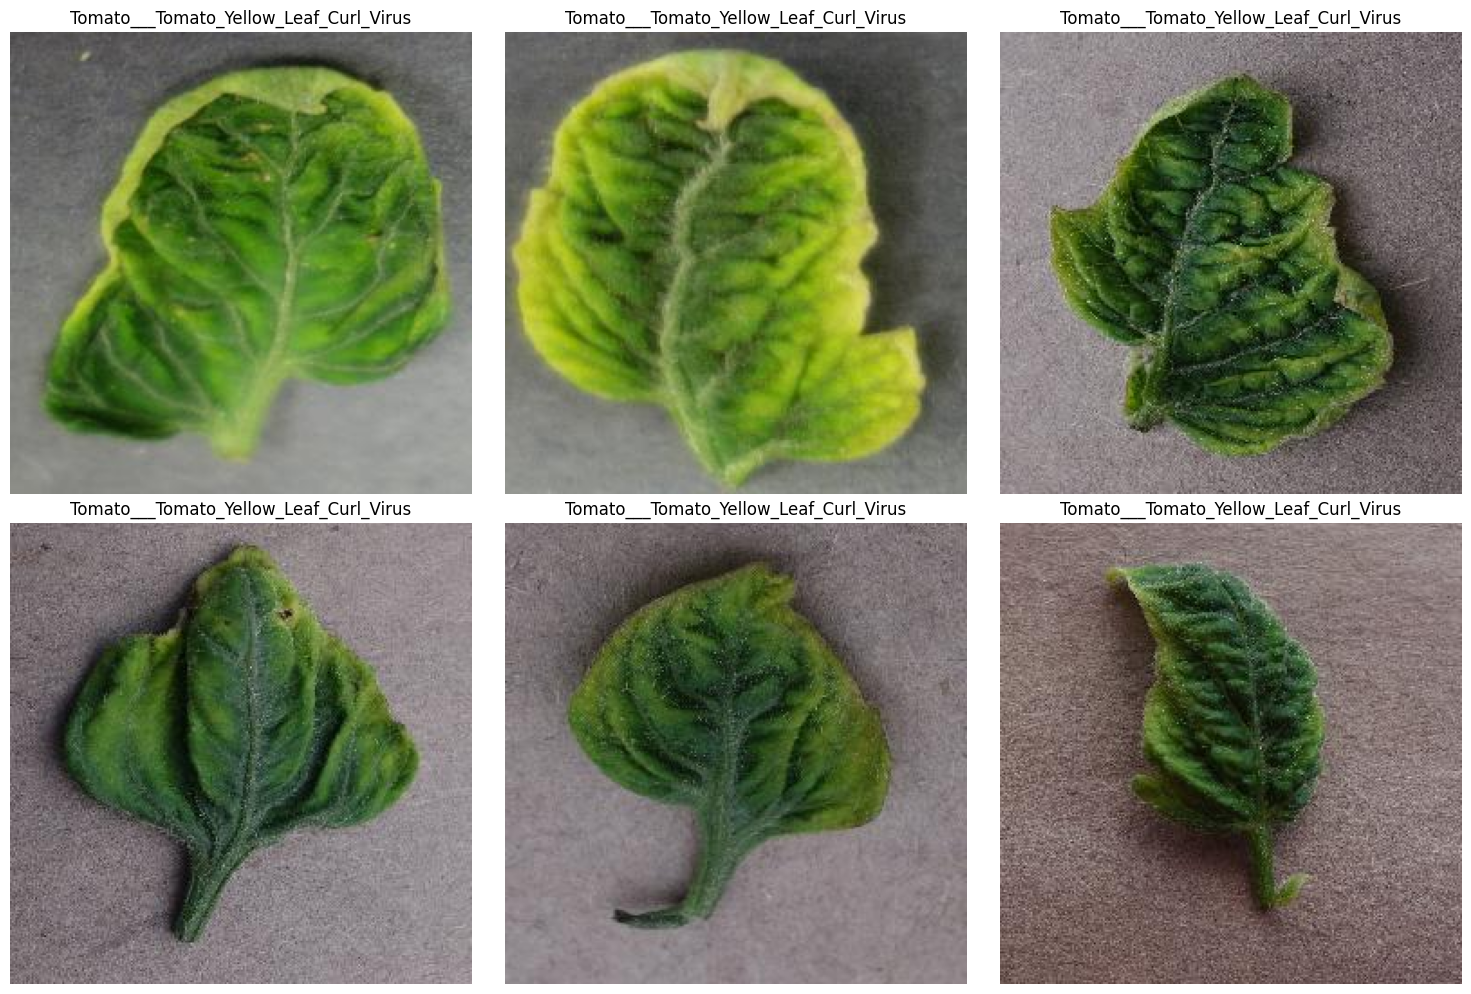

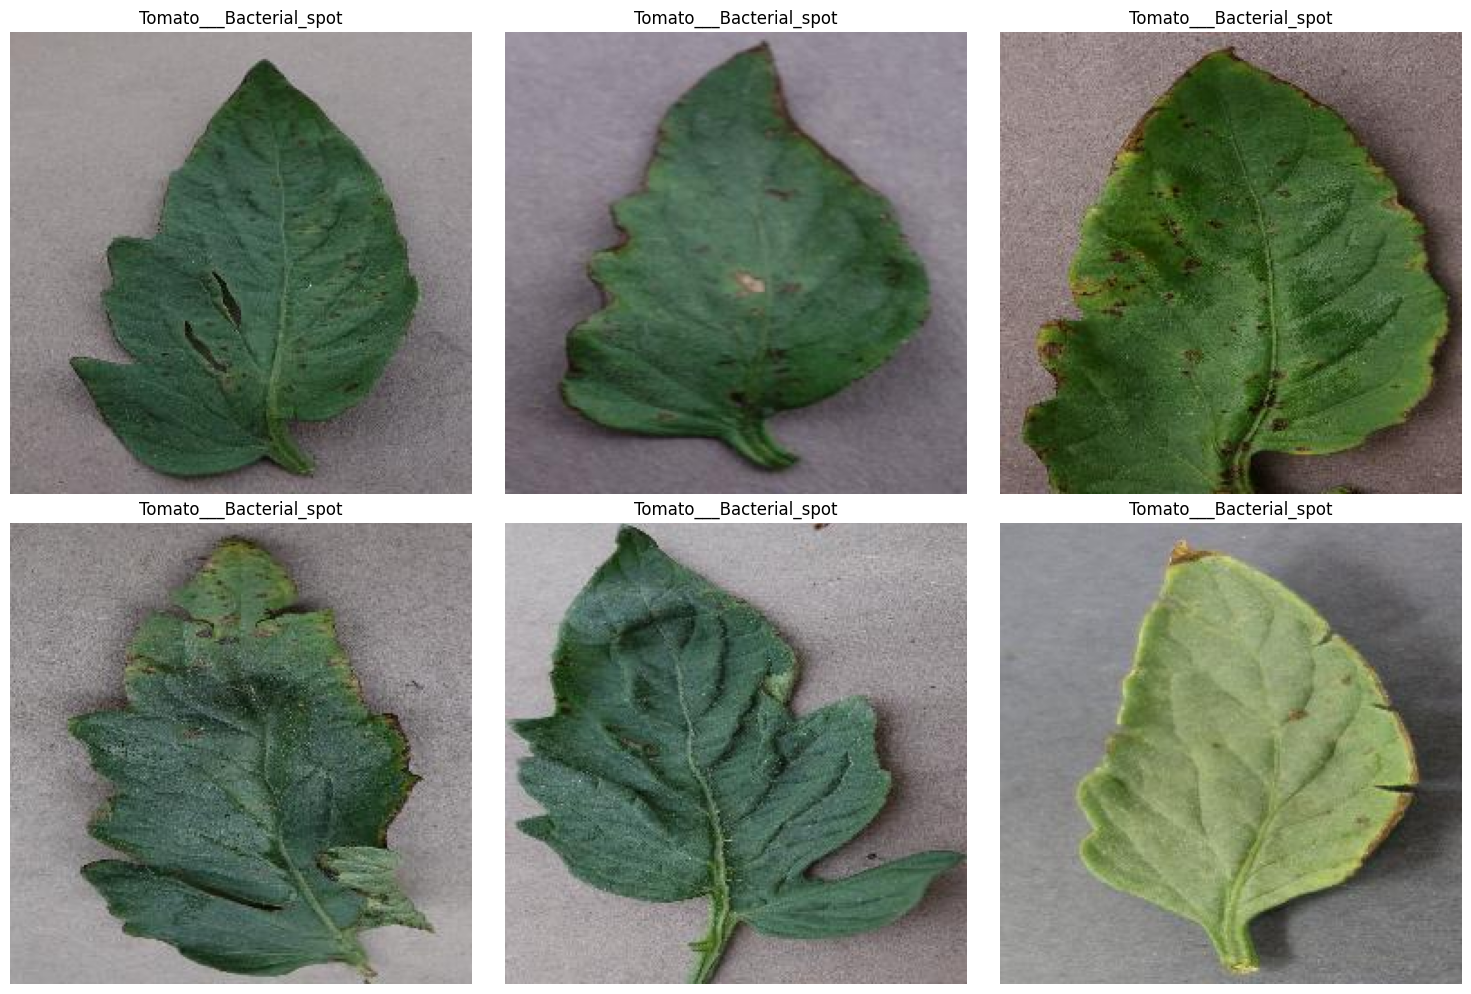

In [3]:
# 3 | Visualize Images
def show_sample_images(class_folder):
    path = f"/kaggle/input/tomatoleaf/tomato/train/{class_folder}"
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))][:6]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    for i, image_file in enumerate(image_files):
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(class_folder)
    plt.tight_layout()
    plt.show()

# Display two classes
show_sample_images("Tomato___Tomato_Yellow_Leaf_Curl_Virus")
show_sample_images("Tomato___Bacterial_spot")

In [4]:
# 4 | Build DenseNet Model (Without Pretrained Weights)
conv_base = DenseNet121(
    weights=None,  # <--- No internet needed
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)
conv_base.trainable = True

model = Sequential([
    conv_base,
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(10, activation='softmax')
])


In [5]:
# 5 | Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# 6 | Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=25,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]
)

Epoch 1/25


I0000 00:00:1750413464.536282      66 service.cc:148] XLA service 0x78bb54009150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750413464.537011      66 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750413473.405979      66 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1750413546.930998      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 ━━━━━━━━━━━━━━━━━━━━ 324s 488ms/step - accuracy: 0.2854 - loss: 2.2103 - val_accuracy: 0.0990 - val_loss: 5.1061 - learning_rate: 1.0000e-04
Epoch 2/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.6081 - loss: 1.1666 - val_accuracy: 0.3650 - val_loss: 2.2195 - learning_rate: 1.0000e-04
Epoch 3/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 58s 187ms/step - accuracy: 0.7131 - loss: 0.8756 - val_accuracy: 0.6390 - val_loss: 1.2893 - learning_rate: 1.0000e-04
Epoch 4/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.7823 - loss: 0.6846 - val_accuracy: 0.4120 - val_loss: 2.4777 - learning_rate: 1.0000e-04
Epoch 5/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 188ms/step - accuracy: 0.8039 - loss: 0.6159 - val_accuracy: 0.7920 - val_loss: 0.6519 - learning_rate: 1.0000e-04
Epoch 6/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 187ms/step - accuracy: 0.8381 - loss: 0.5088 - val_accuracy: 0.5260 - val_loss: 2.3357 - learning_rate: 1.0000e-04
Epoch 7/25
313/313 ━━━━━━━━━━━━━━━━━━━━ 59s 188ms/step -

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 1024)                │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,028,448 (87.85 MB)

 Trainable params: 7,647,242 (29.17 MB)

 Non-trainable params: 86,720 (338.75 KB)

 Optimizer params: 15,294,486 (58.34 MB)

In [8]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_data, verbose=0)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Optional: Evaluate on training data
train_loss, train_accuracy = model.evaluate(train_data, verbose=0)
print(f"Training Loss: {train_loss:.4f}")
print(f"Training Accuracy: {train_accuracy:.4f}")

# Optional: If you have test_data, evaluate on it too
# test_loss, test_accuracy = model.evaluate(test_data, verbose=0)
# print(f"Test Loss: {test_loss:.4f}")
# print(f"Test Accuracy: {test_accuracy:.4f}")


Validation Loss: 0.1034
Validation Accuracy: 0.9680
Training Loss: 0.0197
Training Accuracy: 0.9943


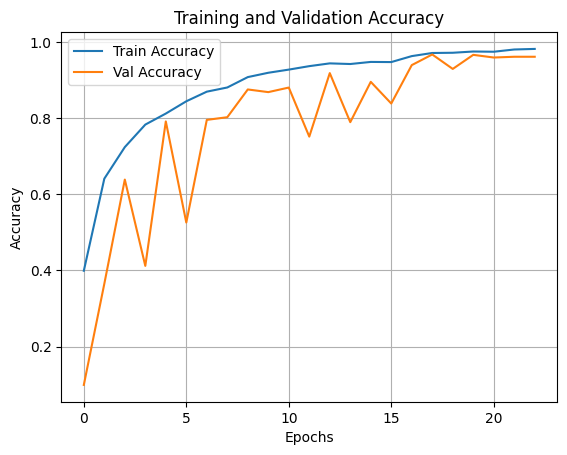

In [9]:
# 8 | Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Load train data and keep class names
train_raw = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)
class_names = train_raw.class_names  # ✅ Save class names before mapping
train_data = train_raw.map(lambda x, y: (x / 255.0, y))

# Load validation data
val_raw = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32
)
val_data = val_raw.map(lambda x, y: (x / 255.0, y))


Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 407ms/step


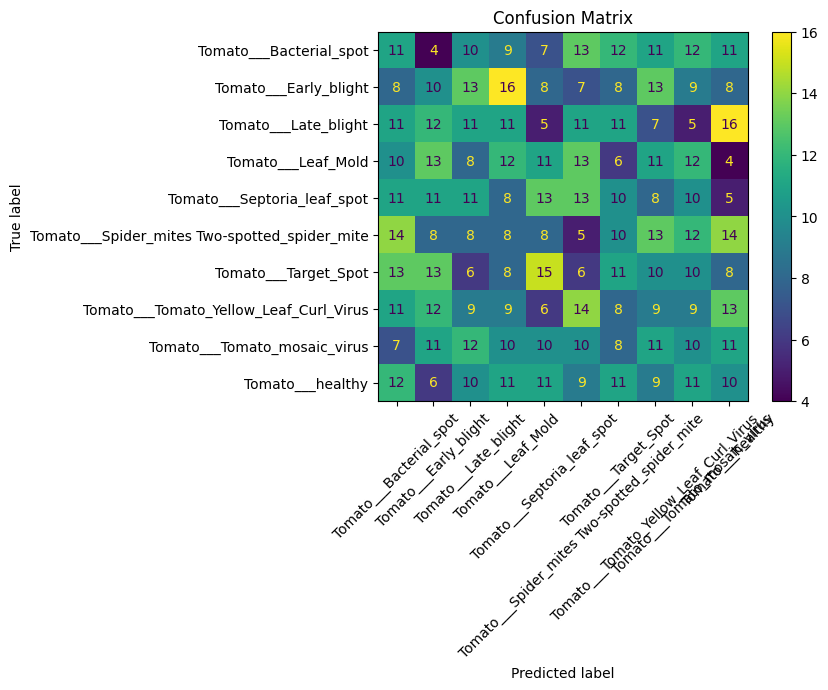

In [11]:
# 9 | Confusion Matrix
y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred_probs = model.predict(val_data)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
